In [95]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats
pd.options

In [96]:
# Choose ETF with a minimum of 100 assets
state_street = list(pd.read_excel("https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx", header=4).dropna().Ticker)
blackrock = list(pd.read_csv("https://www.blackrock.com/us/individual/products/239726/ishares-core-sp-500-etf/1464253357814.ajax?fileType=csv&fileName=IVV_holdings&dataType=fund", header = 9).Ticker.dropna())

tickers = list(set(state_street) & set(blackrock))

In [97]:
# Retrieve data of all tickers within S&P 500
data = yf.download(tickers,period='10y')[["Adj Close", "Volume"]]
data = data.dropna(how='all',axis=1)
close = data['Adj Close']
volume = data['Volume']
returns = data['Adj Close'].pct_change().resample("M").sum().shift(-1)

display(data)

[*********************100%***********************]  501 of 501 completed


Adj Close                                                 \
                     A        AAL         AAP        AAPL        ABBV   
Date                                                                    
2013-05-13   28.229774  16.705374   78.215607   14.100141   29.653925   
2013-05-14   28.839762  17.063618   79.246223   13.762783   30.193205   
2013-05-15   29.961349  17.732965   79.503891   13.297370   30.645948   
2013-05-16   29.508776  18.025213   78.602066   13.475038   30.765779   
2013-05-17   29.882633  17.921513   79.283020   13.434110   31.404951   
...                ...        ...         ...         ...         ...   
2023-05-08  132.449997  14.360000  125.750000  173.260345  147.449997   
2023-05-09  127.349998  14.470000  125.519997  171.532745  146.830002   
2023-05-10  128.059998  14.340000  125.800003  173.320267  146.419998   
2023-05-11  127.660004  14.070000  124.169998  173.510010  146.589996   
2023-05-12  127.489998  14.020000  122.860001  172.570007  147.149994   

                                                                       ...  \
                   ABC         ABT       ACGL         ACN        ADBE  ...   
Date                                                                   ...   
2013-05-13   46.519901   30.031919  17.986668   66.749565   43.610001  ...   
2013-05-14   46.929756   30.610264  18.163334   67.275742   44.040001  ...   
2013-05-15   46.972454   31.114222  18.146667   67.451118   45.070000  ...   
2013-05-16   46.629589   30.428497  17.813334   67.325859   44.560001  ...   
2013-05-17   47.135319   30.230211  17.856667   68.687241   44.610001  ...   
...                ...         ...        ...         ...         ...  ...   
2023-05-08  167.728699  110.900002  76.139999  264.820007  344.059998  ...   
2023-05-09  167.768570  110.250000  76.610001  263.480011  342.649994  ...   
2023-05-10  169.014999  110.690002  77.220001  268.890015  344.019989  ...   
2023-05-11  171.440002  110.050003  77.309998  272.269989  341.579987  ...   
2023-05-12  170.990005  110.489998  76.900002  277.190002  335.450012  ...   

             Volume                                                         \
               WYNN      XEL       XOM     XRAY      XYL      YUM      ZBH   
Date                                                                         
2013-05-13  1252100  3107700   9810100  1034500  1150200  6619769  1150407   
2013-05-14   917300  3900000   9890300  1104200  1665300  3810088   982826   
2013-05-15  1328500  2794900  10399400   975900  1695900  4646636  1177805   
2013-05-16   957600  1862300  10469600  1452600   799000  3872266  1031236   
2013-05-17   983200  2437000  12721300   998700   502700  3929575  1469398   
...             ...      ...       ...      ...      ...      ...      ...   
2023-05-08  1836700  2171000  11187800   974400  1523300   981400  1304500   
2023-05-09  3359700  2102800  11370800  1670900  1452700  1094900  1017600   
2023-05-10  5041500  2963100  14884800  1027000  1344700  1595200  1163400   
2023-05-11  4509700  2850100  17165900   932600  1278700  1144100   899700   
2023-05-12  2653500  2295800  12608300   794000  1242700  1114700   840700   

                                       
              ZBRA      ZION      ZTS  
Date                                   
2013-05-13  177800   1729200   438700  
2013-05-14  214000   1470500   872300  
2013-05-15  237400   2333000   563200  
2013-05-16   87700   2042300  1278700  
2013-05-17  143100   1683800   962200  
...            ...       ...      ...  
2023-05-08  384100  12038700  1976100  
2023-05-09  432900   4999300  1904200  
2023-05-10  257400   5689100  1610500  
2023-05-11  349400   7247700  1539100  
2023-05-12  221500   6214400  1267700  

[2519 rows x 1002 columns]

In [106]:
# Calculate the price momentum factors for each asset in ETF
class Momentum_Factors():
    def __init__(self, stock_data, tickers):
        self.price = close
        self.volume = volume
        self.returns = returns
        self.tickers = tickers
        
        self.mom_factors_df = pd.DataFrame(index = self.tickers)
        
    def fifty_two_trend_line(self):
        self.fifty_two_trend_line_df = pd.DataFrame(index=self.tickers)
        
        for i in range (1,21):
            self.fifty_two_trend_line_df[i] = np.polyfit(range(len(self.price[-i - 252 : -i])), self.price[-i -252 : -i], 1)[0]
        return self.fifty_two_trend_line_df.mean(axis=1)
    
    
    def factors(self):
        
        self.roll_min = self.price.rolling(252).min()
        self.mom_factors_df["pct_above"] = ((self.price - self.roll_min) / self.roll_min)[-20:].mean()
        
        self.mom_factors_df["price_oscillator"] = ((self.price.rolling(20).mean() - self.price.rolling(260).mean())
          /self.price.rolling(260).std())[-20:].mean()
        
        self.mom_factors_df["39_wk_ret"] = self.price.pct_change(189)[-20:].mean()
        
        self.mom_factors_df["price_volume"] = (
            (self.returns * self.volume).rolling(252).sum()[-20:].mean())
        
        self.mom_factors_df["fifty_two_trend_line"] = self.fifty_two_trend_line()
        
        return self.mom_factors_df
    
    def aggregate(self):
        self.mom_factors_df = self.factors()
        self.scored = ((self.mom_factors_df - self.mom_factors_df.mean()) / self.mom_factors_df.std()).sum(axis=1)
        return self.scored
        
    def baskets(self):
        self.z_scored = self.aggregate()
        return self.z_scored.nlargest(10).index, self.z_scored.nsmallest(10).index
    
    

In [107]:
# Calculate the monthly z-factor score for each asset & Identify long and Short baskets
dates_range = pd.DataFrame(pd.date_range("2013-5-14", dt.datetime.today(), freq="M"))
dates_range.rename(columns={0: "date"}, inplace=True)
long_returns, short_returns = pd.DataFrame(), pd.DataFrame()


for date in dates_range.date:
  MF = Momentum_Factors(data[data.index <= date], tickers)
  longs, short = MF.baskets()

  long_returns = long_returns.append(returns[longs].loc[date])
  short_returns = short_returns.append(returns[short].loc[date])
    

In [108]:
long_returns.iloc[-1].dropna()

FSLR    0.269681
EMN    -0.067279
AXON   -0.029311
STLD   -0.065118
GE     -0.000973
NVDA    0.023654
WYNN   -0.078824
META   -0.026995
RCL     0.143122
LVS    -0.058833
Name: 2023-04-30 00:00:00, dtype: float64

In [109]:
# Backtesting for 5 years
alltble = pd.DataFrame(long_returns.mean(axis=1) - short_returns.mean(axis=1)).shift()
alltble = alltble[-60:]

alltble['Return[Cumulative]'] = np.exp(np.log1p(alltble).cumsum())

alltble['Bench'] = yf.download('SPY', period = '6y')['Adj Close'].pct_change().resample('M').sum()

alltble['SPY [Cumulative]'] = np.exp(np.log1p(alltble['Bench']).cumsum())

alltble['Positive?'] = alltble[0] > 0

alltble['cVs'] = alltble['Return[Cumulative]'] - alltble['SPY [Cumulative]']
alltble['is it [Cumul.] Positive?'] = alltble['cVs'] > 0
    
alltble.index = alltble.index.date
alltble=alltble.round(3)
alltble

[*********************100%***********************]  1 of 1 completed


,0,Return[Cumulative],Bench,SPY [Cumulative],Positive?,cVs,is it [Cumul.] Positive?
2018-05-31,0.123,1.123,0.024,1.024,True,0.098,True
2018-06-30,-0.054,1.061,0.006,1.031,False,0.031,True
2018-07-31,-0.008,1.053,0.037,1.068,False,-0.015,False
2018-08-31,-0.067,0.983,0.032,1.102,False,-0.119,False
2018-09-30,-0.038,0.945,0.006,1.109,False,-0.164,False
2018-10-31,-0.084,0.866,-0.069,1.032,False,-0.166,False
2018-11-30,-0.064,0.810,0.020,1.052,False,-0.242,False
2018-12-31,0.090,0.884,-0.089,0.959,True,-0.076,False
2019-01-31,0.032,0.912,0.078,1.034,True,-0.123,False
2019-02-28,-0.039,0.876,0.032,1.068,False,-0.191,False


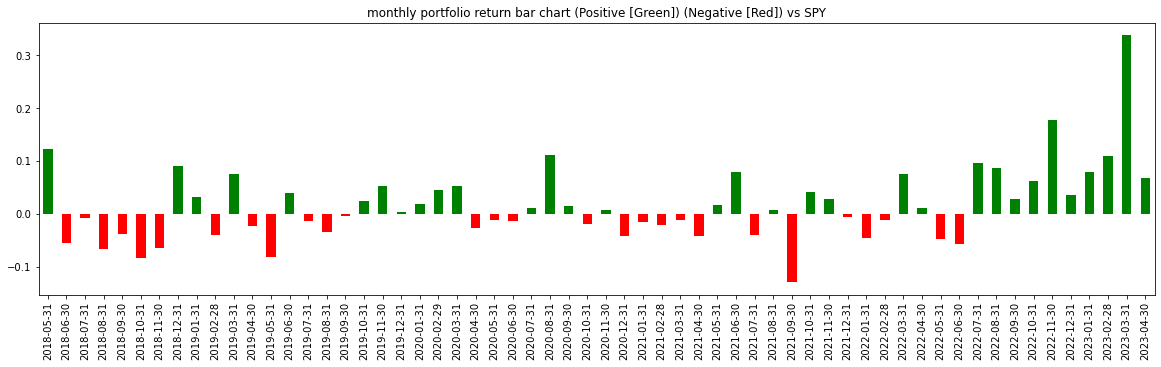

In [110]:
# Chart 1
alltbleP1 = plt.subplots(figsize = (20,5))
alltbleP1 = alltble[0].plot(kind = 'bar',color = alltble['Positive?'].map({True: 'g', False: 'r' }))
plt.title('monthly portfolio return bar chart (Positive [Green]) (Negative [Red]) vs SPY')
plt.show()

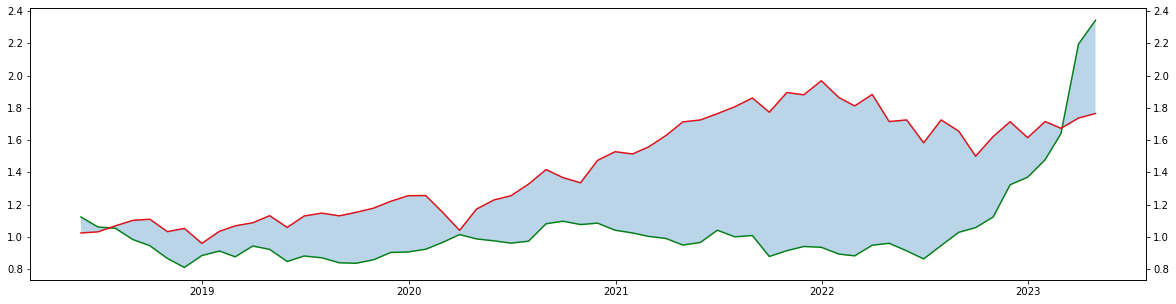

In [111]:
# Chart 2
pt2, alltbleP2 = plt.subplots(figsize = (20, 5))
allf = alltbleP2.twinx()
x = alltble.index
allf.fill_between(x, alltble['Return[Cumulative]'], alltble['SPY [Cumulative]'], alpha = 0.30)
alltbleP2.plot(x, alltble['Return[Cumulative]'], color = 'green')
alltbleP2.plot(x, alltble['SPY [Cumulative]'], color = 'red')
plt.show()

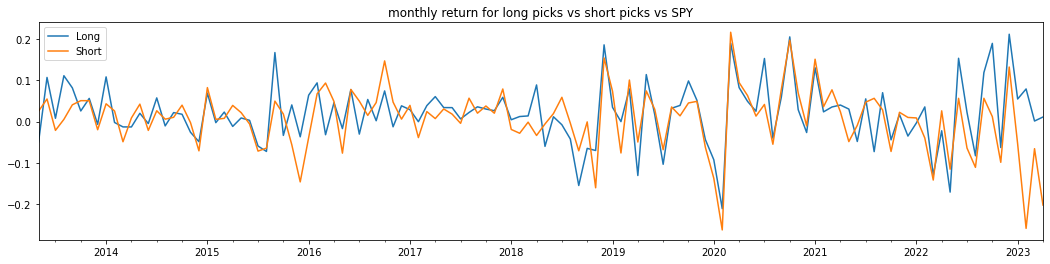

In [112]:
# Chart 3
alltbleP3 = plt.subplots(figsize=(18,4))
long_returns.mean(axis=1).plot(label = 'Long')
short_returns.mean(axis=1).plot(label = 'Short')
plt.legend(['Long', 'Short'])
plt.title('monthly return for long picks vs short picks vs SPY')
plt.show()

In [113]:
# Citation
- Credit given to Professor John Droescher 
- Hilpisch, Y. (2015). Python for finance. O'Reilly Media. 
- https://medium.com/geekculture/beating-the-market-with-a-momentum-trading-strategy-using-python-how-you-can-too-18195a9b23fd
- https://medium.datadriveninvestor.com/unleashing-the-power-of-momentum-trading-with-python-b878b7b5f805
- https://www.dropbox.com/sh/4lh6us99gj8aaob/AADtawNPwJLxU1fI4JCYcGYWa?dl=0
- https://stackoverflow.com/questions/25550308/pyplot-bar-chart-of-positive-and-negative-values

SyntaxError: invalid syntax (1962988393.py, line 2)